<a href="https://colab.research.google.com/github/GOKUALAN/DATABASE/blob/main/RetoDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importación de librerías y configuración inicial

Se cargan las librerías esenciales para el proyecto, incluyendo:

- Herramientas para el manejo y la limpieza de texto.  
- Funciones para organizar los datos en estructuras tipo tabla.  
- Módulos para generar visualizaciones y explorar resultados.  
- Utilidades para dividir el conjunto de datos en entrenamiento y prueba.  
- Métodos para convertir el texto en representaciones numéricas (por ejemplo, TF-IDF).  
- Algoritmos de clasificación para entrenar y comparar distintos modelos.  
- Métricas para evaluar el desempeño de los modelos y herramientas para guardar los modelos entrenados.

Finalmente, se fija una semilla aleatoria para garantizar la reproducibilidad de los resultados.


In [1]:
# ===== Importaciones =====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Carga del dataset AMI desde archivo CSV

En este apartado se incorpora al entorno de trabajo el archivo `es_AMI_TrainingSet.csv`, que contiene los ejemplos etiquetados del corpus AMI. El script:

- Lee el archivo CSV y lo carga en una estructura tipo tabla.
- Estandariza los nombres de las columnas para trabajar con una nomenclatura consistente.
- Define explícitamente las variables principales:
  - `text`: contenido del mensaje.
  - `misogynous`: indica si el mensaje es misógino o no.
  - `misogyny_category`: categoría o tipo de misoginia presente.
  - `target`: grupo o persona hacia la que se dirige el mensaje.

Finalmente, se muestran el número de registros y columnas, así como una muestra de las primeras filas del dataset, para verificar que la carga de datos se haya realizado correctamente.


In [2]:
from google.colab import files

print("Sube tu CSV (por ejemplo, es_AMI_TrainingSet.csv)")
uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]

df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.lower()

df = df.rename(columns={
    'id': 'id',
    'tweet': 'text',
    'misogynous': 'misogynous',
    'misogyny_category': 'misogyny_category',
    'target': 'target'
})

df.head(5)


Sube tu CSV (por ejemplo, es_AMI_TrainingSet.csv)


Saving es_AMI_TrainingSet_NEW.csv to es_AMI_TrainingSet_NEW (1).csv


,id,text,misogynous,misogyny_category,target
0,1,Módulo 01 Invitados Directivos del Sindicato '...,0,0,0
1,2,"@Causafiebres Claro, es que ha puesto imbécil ...",0,0,0
2,3,@Nanchinho A ver si haces algo que sirva para ...,1,discredit,active
3,4,@Rafhyta86 @ElDesmadre__ Habe pasame el video ...,1,discredit,passive
4,5,@Otb_35 Que te calles so guarra.,1,dominance,active


### Limpieza del texto y creación de variables numéricas

En esta sección se preparan los textos antes de entrenar los modelos. El script:

- Aplica funciones de limpieza y normalización del contenido, que incluyen:
  - Reemplazo de emojis por descripciones textuales.
  - Eliminación de URLs, menciones y hashtags.
  - Estandarización de caracteres (por ejemplo, manejo de tildes y símbolos).
- Genera variables numéricas derivadas de cada tweet, tales como:
  - Número de URLs, hashtags y emojis.
  - Longitud del mensaje.
  - Proporción de letras en mayúsculas u otros indicadores de estilo.
- Implementa filtros de calidad sobre el dataset:
  - Eliminación de registros duplicados.
  - Unificación y estandarización de las etiquetas de salida.

Con ello se obtiene un conjunto de datos consistente y estructurado, listo para alimentar los modelos de clasificación.


In [3]:
# Mapa básico de emojis -> tokens
emoji_map = {
    r"😂|🤣": "<emoji_risa>",
    r"😡|🤬": "<emoji_enojo>",
    r"😍|❤|❤️|💖|💕|💘": "<emoji_amor>",
    r"😢|😭": "<emoji_triste>",
    r"😉|😊": "<emoji_sonrisa>",
    r"👍": "<emoji_ok>",
}

def clean_text(x: str) -> str:
    if not isinstance(x, str):
        return ""
    x = x.strip().lower()
    for pat, tok in emoji_map.items():
        x = re.sub(pat, f" {tok} ", x)
    x = re.sub(r"http\S+|www\.\S+", " <url> ", x)
    x = re.sub(r"@[a-z0-9_]+", " <user> ", x)
    x = re.sub(r"#([\wáéíóúñ]+)", r" \1 ", x)
    x = re.sub(r"\s+", " ", x)
    return x.strip()

# Filtrado básico y texto limpio
df = df[df['text'].notna()]
df = df[df['text'].str.len() > 3]
df = df.drop_duplicates(subset=['text']).copy()
df['text_clean'] = df['text'].apply(clean_text)

# Features numéricas auxiliares
def add_meta_features(s: pd.Series) -> pd.DataFrame:
    original = s.fillna("")
    text = original
    return pd.DataFrame({
        'n_url': original.str.count(r"http\S+|www\.\S+"),
        'n_user': original.str.count(r"@[A-Za-z0-9_]+"),
        'n_hash': original.str.count(r"#([\wáéíóúñ]+)"),
        'n_emoji': original.str.count("|".join(list(emoji_map.keys()))),
        'n_char': original.str.len(),
        'upper_ratio': (
            original.str.count(r"[A-ZÁÉÍÓÚÑ]") /
            original.str.len().clip(lower=1)
        )
    })

meta = add_meta_features(df['text'])
for col in meta.columns:
    df[col] = meta[col].astype(float)

# Normalizar etiquetas
df['misogynous'] = df['misogynous'].astype(int)

df['misogyny_category'] = (
    df['misogyny_category']
    .fillna('none')
    .replace({'0': 'none', 'None': 'none'})
    .astype(str)
)

df['target'] = (
    df['target']
    .astype(str)
    .str.lower()
    .replace({
        'activo': 'active', '1': 'active',
        'pasivo': 'passive', '0': 'passive'
    })
    .fillna('passive')
)

df.head(5)


,id,text,misogynous,misogyny_category,target,text_clean,n_url,n_user,n_hash,n_emoji,n_char,upper_ratio
0,1,Módulo 01 Invitados Directivos del Sindicato '...,0,none,passive,módulo 01 invitados directivos del sindicato '...,1.0,0.0,0.0,0.0,132.0,0.098485
1,2,"@Causafiebres Claro, es que ha puesto imbécil ...",0,none,passive,"<user> claro, es que ha puesto imbécil y mucha...",0.0,1.0,0.0,0.0,128.0,0.015625
2,3,@Nanchinho A ver si haces algo que sirva para ...,1,discredit,active,<user> a ver si haces algo que sirva para mejo...,0.0,2.0,0.0,0.0,89.0,0.022472
3,4,@Rafhyta86 @ElDesmadre__ Habe pasame el video ...,1,discredit,passive,<user> <user> habe pasame el video donde adan ...,0.0,2.0,0.0,0.0,150.0,0.280000
4,5,@Otb_35 Que te calles so guarra.,1,dominance,active,<user> que te calles so guarra.,0.0,1.0,0.0,0.0,32.0,0.062500


### Definición de vectorizadores TF-IDF y pipeline general

En esta sección se define la función `make_preprocess()`, encargada de construir el bloque de preprocesamiento que se aplica antes de entrenar los modelos. Este bloque utiliza un `ColumnTransformer` que integra:

- Un vectorizador TF-IDF de palabras (uni- y bigramas).
- Un vectorizador TF-IDF de caracteres (n-gramas de longitud 3 a 5).
- Las seis variables numéricas generadas a partir de los metadatos de cada tweet.

Además, se implementan funciones auxiliares para el flujo completo del modelado:

- `report_metrics()`: calcula e imprime las métricas de desempeño (accuracy, precision, recall, F1 y matriz de confusión).
- `train_eval_task()`: entrena y evalúa modelos independientes para cada tarea de clasificación.
- `best_model()`: selecciona el modelo con mejor desempeño según la métrica F1 macro.

Una corrección relevante es que cada modelo se entrena siempre con un bloque de preprocesamiento nuevo, lo que evita problemas de incompatibilidad en las dimensiones de las features al reutilizar transformadores entre tareas.


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

FEATURE_COLS_NUM = ['n_url','n_user','n_hash','n_emoji','n_char','upper_ratio']

def make_preprocess():
    word_vect = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3
    )
    char_vect = TfidfVectorizer(
        analyzer='char',
        ngram_range=(3,5),
        min_df=3
    )
    return ColumnTransformer(
        transformers=[
            ('word_tfidf', word_vect, 'text_clean'),
            ('char_tfidf', char_vect, 'text_clean'),
            ('num', 'passthrough', FEATURE_COLS_NUM),
        ]
    )

def report_metrics(y_true, y_pred, title=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)
    cm   = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

    print("\n", "="*len(title), f"\n{title}\n", "="*len(title), sep="")
    print(f"Accuracy: {acc:.4f} | Precision(macro): {prec:.4f} | Recall(macro): {rec:.4f} | F1(macro): {f1:.4f}")
    print("Labels:", np.unique(y_true))
    print("Confusion matrix:\n", cm)

    return {
        'accuracy': acc,
        'precision_macro': prec,
        'recall_macro': rec,
        'f1_macro': f1
    }

def train_eval_task(df, target_col, model_dict, test_size=0.2, stratify=True):
    X = df[['text_clean'] + FEATURE_COLS_NUM].copy()
    y = df[target_col].copy()

    strat = y if stratify else None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=RANDOM_SEED,
        stratify=strat
    )

    results = {}

    for name, clf in model_dict.items():
        pipe = Pipeline([
            ('prep', make_preprocess()),               # 💡 preprocess NUEVO
            ('scale', StandardScaler(with_mean=False)),
            ('clf', clf)
        ])

        pipe.fit(X_train, y_train)

        # Train
        yhat_tr = pipe.predict(X_train)
        metrics_tr = report_metrics(
            y_train, yhat_tr,
            title=f"{target_col} – {name} (TRAIN)"
        )

        # Test
        yhat_te = pipe.predict(X_test)
        metrics_te = report_metrics(
            y_test, yhat_te,
            title=f"{target_col} – {name} (TEST)"
        )

        results[name] = {
            'train': metrics_tr,
            'test':  metrics_te,
            'model': pipe
        }

    return results

def best_model(result_dict, key='f1_macro'):
    best_name, best_score, best_pipe = None, -1, None
    for name, d in result_dict.items():
        score = d['test'].get(key, 0.0)
        if score > best_score:
            best_name  = name
            best_score = score
            best_pipe  = d['model']
    return best_name, best_score, best_pipe


### Descripción de los modelos de clasificación utilizados

#### Regresión Logística con regularización L1 (LASSO)
Modelo lineal de clasificación que estima la probabilidad de pertenecer a cada clase. La regularización L1 penaliza los coeficientes grandes y tiende a llevar algunos de ellos a cero, funcionando como un mecanismo de selección de variables. Esto es especialmente útil en problemas de alta dimensión, como los que resultan de usar representaciones TF-IDF del texto.

#### Random Forest
Modelo de ensamble basado en la combinación de múltiples árboles de decisión. Cada árbol se entrena sobre una muestra distinta de los datos y las predicciones finales se obtienen mediante votación mayoritaria. Esta estructura permite capturar relaciones no lineales y reduce el riesgo de sobreajuste en comparación con usar un único árbol.

#### SVM Lineal (LinearSVM)
Clasificador lineal que busca el hiperplano que mejor separa las clases, maximizando el margen entre ellas. Suele funcionar muy bien en espacios de alta dimensión y con datos dispersos, como los generados por TF-IDF, por lo que es un modelo especialmente competitivo en tareas de clasificación de texto.


### Entrenamiento de modelos para la Tarea A (*misogynous*)

En esta sección se entrena un conjunto de modelos para predecir si un mensaje es misógino (`misogynous`). Para ello se construye un diccionario con tres clasificadores:

- Regresión logística con regularización L1 (LASSO).
- Random Forest.
- SVM lineal (LinearSVM).

Cada modelo se entrena dentro de un mismo *pipeline* que integra:

- El preprocesamiento del texto (vectorizadores TF-IDF de palabras y de caracteres).
- Las variables numéricas derivadas de los metadatos del tweet.
- El escalado adecuado de las features numéricas.

Para cada clasificador se reporta el desempeño en los conjuntos de entrenamiento y prueba. Finalmente, se selecciona como modelo final para la Tarea A aquel que obtiene el mayor valor de F1 macro.


In [5]:
models_A = {
    'LASSO_LogReg': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        n_jobs=-1
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    'LinearSVM': LinearSVC(
        class_weight='balanced',
        random_state=RANDOM_SEED
    )
}

print("\n>>> Entrenando Tarea A (misogynous)...")
res_A = train_eval_task(df, 'misogynous', models_A, stratify=True)
bestA = best_model(res_A)
print(f"\nMejor A: {bestA[0]}  F1={bestA[1]:.4f}")



>>> Entrenando Tarea A (misogynous)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



misogynous – LASSO_LogReg (TRAIN)
Accuracy: 1.0000 | Precision(macro): 1.0000 | Recall(macro): 1.0000 | F1(macro): 1.0000
Labels: [0 1]
Confusion matrix:
 [[1326    0]
 [   0 1319]]

misogynous – LASSO_LogReg (TEST)
Accuracy: 0.7553 | Precision(macro): 0.7574 | Recall(macro): 0.7551 | F1(macro): 0.7547
Labels: [0 1]
Confusion matrix:
 [[266  66]
 [ 96 234]]

misogynous – RandomForest (TRAIN)
Accuracy: 1.0000 | Precision(macro): 1.0000 | Recall(macro): 1.0000 | F1(macro): 1.0000
Labels: [0 1]
Confusion matrix:
 [[1326    0]
 [   0 1319]]

misogynous – RandomForest (TEST)
Accuracy: 0.7674 | Precision(macro): 0.7677 | Recall(macro): 0.7673 | F1(macro): 0.7673
Labels: [0 1]
Confusion matrix:
 [[261  71]
 [ 83 247]]

misogynous – LinearSVM (TRAIN)
Accuracy: 1.0000 | Precision(macro): 1.0000 | Recall(macro): 1.0000 | F1(macro): 1.0000
Labels: [0 1]
Confusion matrix:
 [[1326    0]
 [   0 1319]]

misogynous – LinearSVM (TEST)
Accuracy: 0.7281 | Precision(macro): 0.7297 | Recall(macro): 0.7280

### Entrenamiento de modelos para la Tarea B (tipo de misoginia)

En esta sección se entrenan clasificadores multiclase para predecir el tipo específico de misoginia asociado a cada mensaje, distinguiendo entre las categorías:

- `stereotype`: refuerza estereotipos de género (ej. “todas las mujeres son…”).
- `dominance`: busca marcar superioridad o control sobre las mujeres.
- `discredit`: descalifica, ridiculiza o minimiza la credibilidad de las mujeres.
- `derailing`: cambia el foco de una discusión sobre machismo para invalidarla o restarle importancia.
- `sexual_harassment`: contiene insinuaciones, comentarios o propuestas de tono sexual no deseado.
- `none`: mensajes sin contenido misógino.

Se utilizan tres modelos:

- Regresión logística multinomial con regularización L1 (LASSO).
- Random Forest.
- SVM lineal (LinearSVM).

Todos los clasificadores se integran en el mismo *pipeline* de preprocesamiento, que combina:

- Vectorizadores TF-IDF de palabras y de caracteres.
- Las variables numéricas derivadas de los metadatos del tweet.
- El escalado de las variables numéricas cuando corresponde.

A diferencia de otros experimentos, en esta tarea se descarta XGBoost, ya que exige etiquetas codificadas como valores numéricos adicionales. Finalmente, se construye un resumen de métricas de desempeño y se selecciona el mejor modelo según el valor de F1 macro.


In [6]:
# ===== Tarea B: tipo de misoginia (multiclase) =====

models_B = {
    'LASSO_Multinomial': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        n_jobs=-1,
        multi_class='multinomial'
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=600,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    'LinearSVM': LinearSVC(
        class_weight='balanced',
        random_state=RANDOM_SEED
    )
    # Nota: quitamos XGBoost aquí porque requiere y numérica (0..num_class-1)
}

print("\n>>> Entrenando Tarea B (misogyny_category)...")
res_B = train_eval_task(df, 'misogyny_category', models_B, stratify=True)
bestB = best_model(res_B)
print(f"\nMejor B: {bestB[0]}  F1={bestB[1]:.4f}")



>>> Entrenando Tarea B (misogyny_category)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



misogyny_category – LASSO_Multinomial (TRAIN)
Accuracy: 0.9962 | Precision(macro): 0.9923 | Recall(macro): 0.9969 | F1(macro): 0.9946
Labels: ['derailing' 'discredit' 'dominance' 'none' 'sexual_harassment'
 'stereotype']
Confusion matrix:
 [[  16    0    0    0    0    0]
 [   0  774    5    0    3    0]
 [   0    1  240    0    1    0]
 [   0    0    0 1326    0    0]
 [   0    0    0    0  158    0]
 [   0    0    0    0    0  121]]

misogyny_category – LASSO_Multinomial (TEST)
Accuracy: 0.6692 | Precision(macro): 0.4994 | Recall(macro): 0.4437 | F1(macro): 0.4658
Labels: ['derailing' 'discredit' 'dominance' 'none' 'sexual_harassment'
 'stereotype']
Confusion matrix:
 [[  0   2   1   1   0   0]
 [  0 110  18  60   5   3]
 [  0  18  28  12   1   1]
 [  4  33   8 277   5   5]
 [  0   6   1  17  16   0]
 [  2   9   1   5   1  12]]

misogyny_category – RandomForest (TRAIN)
Accuracy: 1.0000 | Precision(macro): 1.0000 | Recall(macro): 1.0000 | F1(macro): 1.0000
Labels: ['derailing' 'discr

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



misogyny_category – LinearSVM (TRAIN)
Accuracy: 0.9974 | Precision(macro): 0.9980 | Recall(macro): 0.9949 | F1(macro): 0.9965
Labels: ['derailing' 'discredit' 'dominance' 'none' 'sexual_harassment'
 'stereotype']
Confusion matrix:
 [[  16    0    0    0    0    0]
 [   0  781    1    0    0    0]
 [   0    4  238    0    0    0]
 [   0    0    0 1326    0    0]
 [   0    2    0    0  156    0]
 [   0    0    0    0    0  121]]

misogyny_category – LinearSVM (TEST)
Accuracy: 0.6148 | Precision(macro): 0.4641 | Recall(macro): 0.3610 | F1(macro): 0.3897
Labels: ['derailing' 'discredit' 'dominance' 'none' 'sexual_harassment'
 'stereotype']
Confusion matrix:
 [[  0   2   1   1   0   0]
 [  0  94  19  78   2   3]
 [  0  25  18  13   2   2]
 [  0  38  16 275   3   0]
 [  0  10   0  17  13   0]
 [  1   8   1  13   0   7]]

Mejor B: RandomForest  F1=0.4688


### Entrenamiento de modelos para la Tarea C (*target*)

En esta sección se entrenan modelos de clasificación binaria para identificar si el ataque va dirigido a:

- `active`: una persona específica o un individuo concreto.
- `passive`: un colectivo o grupo general (por ejemplo, “las mujeres”, “las feministas”, etc.).

Se utilizan tres clasificadores:

- Regresión logística con regularización L1 (LASSO).
- Random Forest.
- SVM lineal (LinearSVM).

Todos los modelos se integran en el mismo *pipeline* de preprocesamiento, que combina:

- Vectorizadores TF-IDF de palabras y de caracteres.
- Las variables numéricas derivadas de los metadatos del tweet.
- El escalado de las variables numéricas cuando corresponde.

Para cada clasificador se evalúa el desempeño en los conjuntos de entrenamiento y prueba y se comparan las métricas obtenidas, con el fin de identificar cuál ofrece la mejor capacidad de discriminación entre targets activos y pasivos.


In [7]:
# ===== Tarea C: target (active/passive) =====

models_C = {
    'LASSO_LogReg': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=3000,   # subí un poco max_iter para ayudar a converger
        n_jobs=-1
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        class_weight='balanced',
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),
    'LinearSVM': LinearSVC(
        class_weight='balanced',
        max_iter=5000,   # también más iteraciones aquí
        random_state=RANDOM_SEED
    )
    # Nota: XGBoost fuera porque quiere y numérica (0/1),
    # y aquí trabajamos cómodo con etiquetas 'active'/'passive'.
}

print("\n>>> Entrenando Tarea C (target)...")
res_C = train_eval_task(df, 'target', models_C, stratify=True)
bestC = best_model(res_C)
print(f"\nMejor C: {bestC[0]}  F1={bestC[1]:.4f}")



>>> Entrenando Tarea C (target)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



target – LASSO_LogReg (TRAIN)
Accuracy: 0.9996 | Precision(macro): 0.9996 | Recall(macro): 0.9997 | F1(macro): 0.9996
Labels: ['active' 'passive']
Confusion matrix:
 [[1164    0]
 [   1 1480]]

target – LASSO_LogReg (TEST)
Accuracy: 0.8006 | Precision(macro): 0.7975 | Recall(macro): 0.7991 | F1(macro): 0.7982
Labels: ['active' 'passive']
Confusion matrix:
 [[229  62]
 [ 70 301]]

target – RandomForest (TRAIN)
Accuracy: 1.0000 | Precision(macro): 1.0000 | Recall(macro): 1.0000 | F1(macro): 1.0000
Labels: ['active' 'passive']
Confusion matrix:
 [[1164    0]
 [   0 1481]]

target – RandomForest (TEST)
Accuracy: 0.8233 | Precision(macro): 0.8221 | Recall(macro): 0.8179 | F1(macro): 0.8195
Labels: ['active' 'passive']
Confusion matrix:
 [[225  66]
 [ 51 320]]


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



target – LinearSVM (TRAIN)
Accuracy: 1.0000 | Precision(macro): 1.0000 | Recall(macro): 1.0000 | F1(macro): 1.0000
Labels: ['active' 'passive']
Confusion matrix:
 [[1164    0]
 [   0 1481]]

target – LinearSVM (TEST)
Accuracy: 0.7598 | Precision(macro): 0.7563 | Recall(macro): 0.7568 | F1(macro): 0.7565
Labels: ['active' 'passive']
Confusion matrix:
 [[213  78]
 [ 81 290]]

Mejor C: RandomForest  F1=0.8195


### Guardado de los modelos ganadores

En esta sección se almacenan en disco (por ejemplo, en la ruta `/content/` de Google Colab) los modelos ganadores de las Tareas A, B y C utilizando `joblib.dump()`. De este modo:

- Cada clasificador entrenado se guarda como un archivo independiente.
- Es posible cargar estos modelos posteriormente sin necesidad de repetir todo el proceso de entrenamiento del notebook.
- Se facilita su reutilización en futuras pruebas, experimentos adicionales o etapas de despliegue.

Esto hace más eficiente el flujo de trabajo y permite trabajar directamente con los modelos ya optimizados.


In [8]:
bestA_name, bestA_f1, bestA_model = bestA
bestB_name, bestB_f1, bestB_model = bestB
bestC_name, bestC_f1, bestC_model = bestC

if bestA_model is not None:
    joblib.dump(bestA_model, "/content/best_A_misogynous.joblib")
if bestB_model is not None:
    joblib.dump(bestB_model, "/content/best_B_category.joblib")
if bestC_model is not None:
    joblib.dump(bestC_model, "/content/best_C_target.joblib")

print("Modelos guardados en /content/")


Modelos guardados en /content/


### Funciones de gráficas

En esta sección se definen tres funciones de apoyo para visualizar el desempeño de los modelos:

- `plot_confmat()`: genera la matriz de confusión, permitiendo observar aciertos y errores por clase.
- `plot_roc_pr()`: dibuja las curvas ROC y Precision–Recall para las tareas binarias (A y C), lo que permite evaluar la calidad de la clasificación más allá de una sola métrica.
- `bar_f1_per_class()`: muestra, mediante un gráfico de barras, el valor de F1 obtenido para cada categoría en la Tarea B (multiclase), ayudando a identificar en qué tipos de misoginia el modelo funciona mejor o peor.

Estas visualizaciones complementan las métricas numéricas y permiten un análisis más detallado del comportamiento de los clasificadores.


In [9]:
#  IMPORTS NECESARIOS PARA LAS GRÁFICAS
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def plot_confmat(y_true, y_pred, title="Matriz de confusión"):
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, interpolation='nearest')
    plt.colorbar(im)
    ax.set_title(title)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

def get_scores_binary(model, X, y):
    pos_label = sorted(np.unique(y))[-1]
    try:
        proba = model.predict_proba(X)
        if proba.shape[1] == 2:
            scores = proba[:, 1]
        else:
            idx = list(model.classes_).index(pos_label)
            scores = proba[:, idx]
    except Exception:
        try:
            scores = model.decision_function(X)
        except Exception:
            scores = model.predict(X)
    return scores, pos_label

def plot_roc_pr(model, X_test, y_test, task_name=""):
    scores, pos_label = get_scores_binary(model, X_test, y_test)
    y_bin = (y_test == pos_label).astype(int)

    fpr, tpr, _ = roc_curve(y_bin, scores)
    precision, recall, _ = precision_recall_curve(y_bin, scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"ROC – {task_name}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.3f}")
    plt.title(f"Precisión–Recall – {task_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.show()

def bar_f1_per_class(y_true, y_pred, title="F1 por clase"):
    labels = np.unique(y_true)
    scores = f1_score(y_true, y_pred, average=None, labels=labels, zero_division=0)
    plt.figure(figsize=(7,4))
    plt.bar(range(len(labels)), scores)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.ylim(0,1)
    plt.ylabel("F1")
    plt.title(title)
    plt.tight_layout()
    plt.show()


### Visualización completa de resultados (Tareas A, B y C)

Esta sección genera todos los gráficos finales asociados a cada tarea:

- **Tarea A (detección de misoginia)**: matriz de confusión + curvas ROC y Precision–Recall.
- **Tarea B (tipo de misoginia)**: matriz de confusión multiclase + gráfico de barras con F1 por clase.
- **Tarea C (target active/passive)**: matriz de confusión + curvas ROC y Precision–Recall.

De este modo, se consolida la evaluación visual del modelo y se facilita la interpretación de los errores de clasificación, así como la detección de posibles desequilibrios entre clases.

---

### Informe de las gráficas

#### 1. Tarea A – Detección binaria de misoginia (Random Forest)

**Curva ROC (AUC = 0.850)**  
- Muestra una muy buena capacidad de discriminación entre tuits misóginos y no misóginos.  
- El modelo mantiene tasas de verdaderos positivos altas incluso con niveles moderados de falsos positivos.  

**Curva Precision–Recall (AUC = 0.841)**  
- La precisión se mantiene por encima de 0.90 para valores bajos y medios de *recall*.  
- El modelo identifica con confianza los casos positivos sin sacrificar demasiada cobertura.  
- La curva PR resulta especialmente informativa en contextos desbalanceados y confirma un desempeño robusto.  

**Matriz de confusión**  
- La clase `1` (*misogynous*) presenta algunos falsos negativos (tuits misóginos no detectados).  
- La clase `0` (*no misógino*) muestra falsos positivos, aunque en menor proporción.  
- En conjunto, el modelo logra un compromiso razonable entre sensibilidad y precisión.

---

#### 2. Tarea B – Clasificación del tipo de misoginia (Random Forest)

Esta es la tarea más exigente debido al desbalance severo entre clases.

**Matriz de confusión multiclase**  
- La clase `none` es la más fácil de predecir y domina el dataset (más de 300 aciertos).  
- Las clases minoritarias (`derailing`, `sexual_harassment`, `stereotype`) se confunden con frecuencia con `none` o entre ellas.  
- `discredit` y `dominance` logran un rendimiento intermedio.  
- Este patrón es típico en problemas multiclase con distribuciones muy desiguales de ejemplos.

**F1 por clase**  
- `none`: mejor desempeño (≈ 0.80).  
- `discredit` / `dominance`: desempeño moderado (≈ 0.55–0.60).  
- `sexual_harassment` / `stereotype` / `derailing`: F1 más bajo (≈ 0.30–0.45).  

Las puntuaciones F1 reflejan claramente el impacto del desbalance: las clases con menor representación tienden a obtener peores métricas.

---

#### 3. Tarea C – Clasificación del objetivo (*active/passive*)

En esta tarea binaria, los resultados son más estables.

**Matriz de confusión**  
- La clase `passive` (ataque dirigido a un colectivo o grupo general) es la más sencilla de clasificar.  
- La clase `active` (ataque a una persona específica) concentra más errores, con varios casos confundidos como `passive`.  
- Esto sugiere que, ante la duda, el modelo tiende a asignar la etiqueta más frecuente o menos específica.

**Curva ROC (AUC = 0.882)**  
- El valor de AUC indica una excelente capacidad de discriminación entre objetivos `active` y `passive`.

**Curva Precision–Recall (AUC = 0.883)**  
- La precisión se mantiene alta a lo largo de casi todo el rango de *recall*.  
- El modelo identifica adecuadamente los casos `active` sin deteriorar de forma significativa la precisión global.


Usando mejor modelo A: RandomForest  F1=0.7673


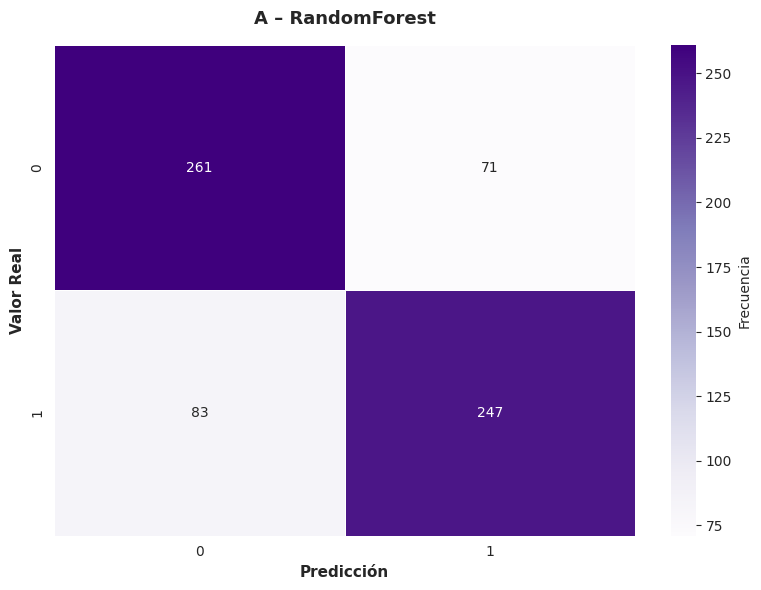


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       332
           1       0.78      0.75      0.76       330

    accuracy                           0.77       662
   macro avg       0.77      0.77      0.77       662
weighted avg       0.77      0.77      0.77       662



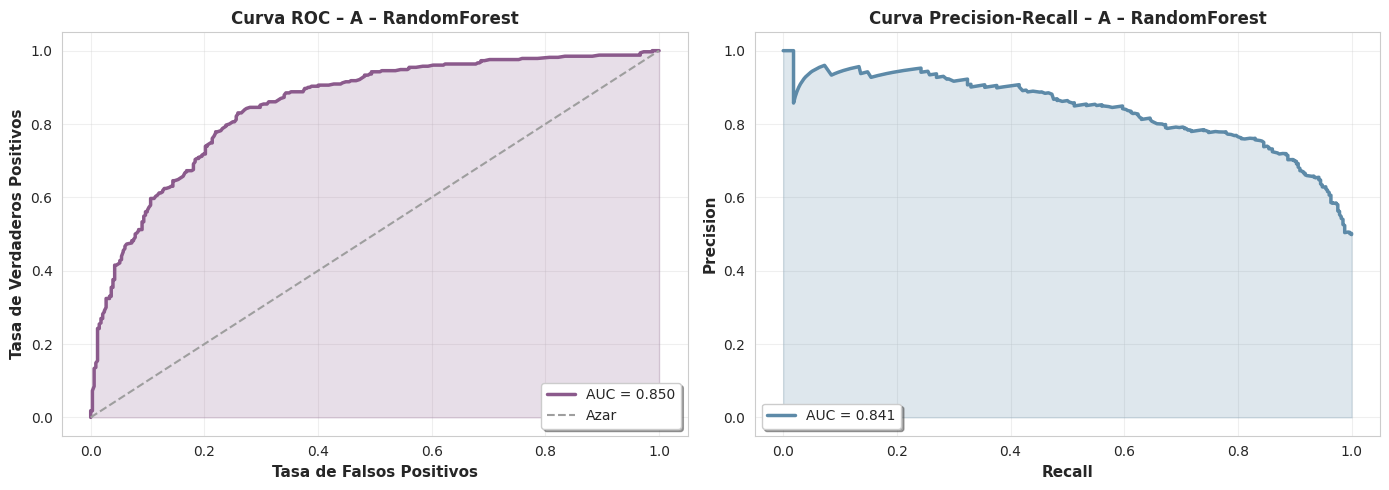


Usando mejor modelo B: RandomForest  F1=0.4688


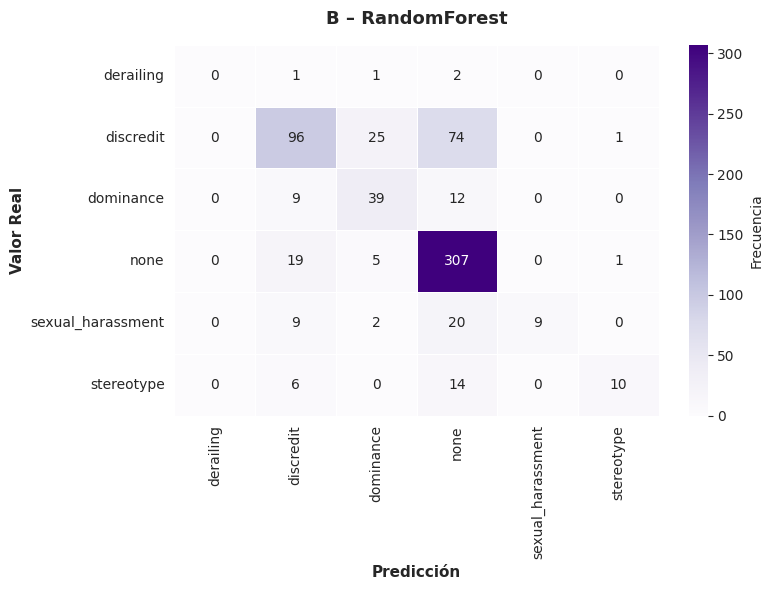


Reporte de Clasificación:
                   precision    recall  f1-score   support

        derailing       0.00      0.00      0.00         4
        discredit       0.69      0.49      0.57       196
        dominance       0.54      0.65      0.59        60
             none       0.72      0.92      0.81       332
sexual_harassment       1.00      0.23      0.37        40
       stereotype       0.83      0.33      0.48        30

         accuracy                           0.70       662
        macro avg       0.63      0.44      0.47       662
     weighted avg       0.71      0.70      0.67       662



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


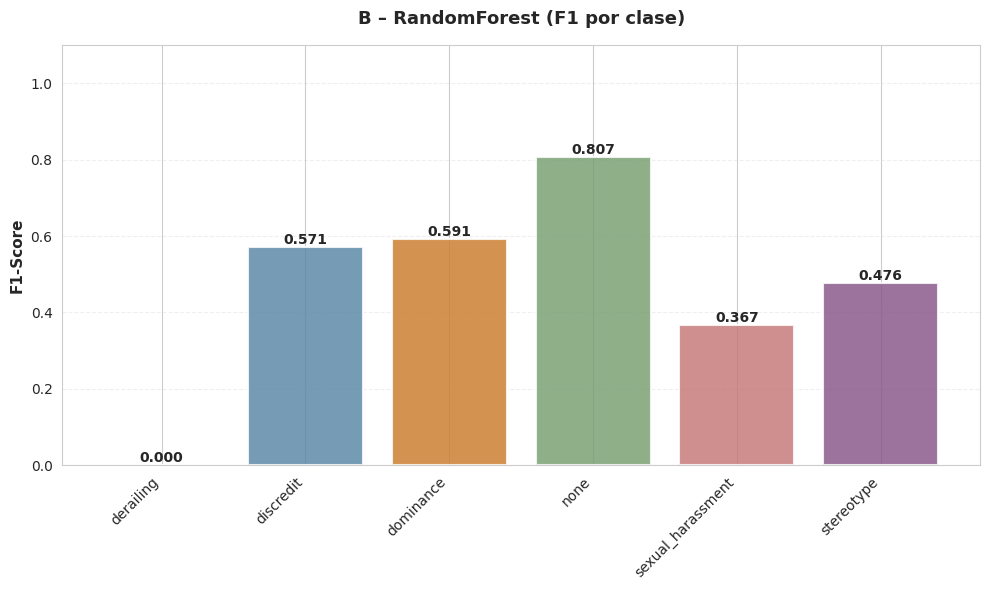


Usando mejor modelo C: RandomForest  F1=0.8195


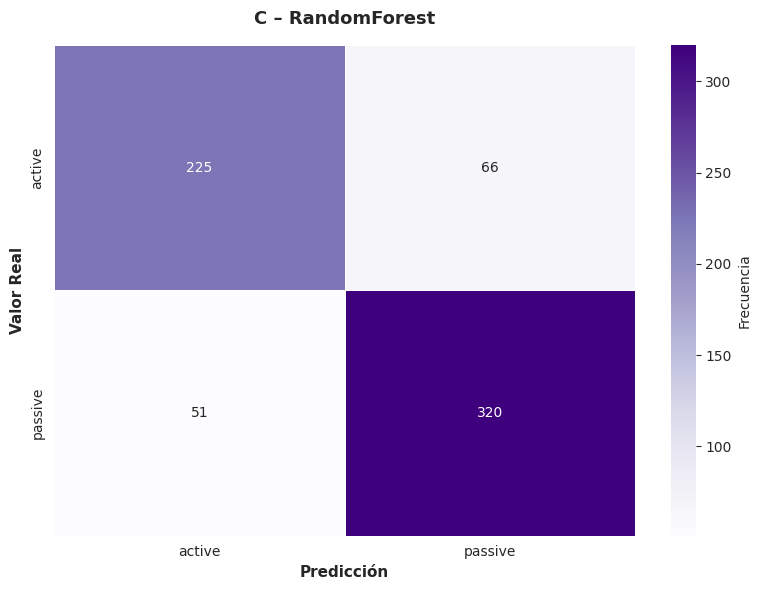


Reporte de Clasificación:
              precision    recall  f1-score   support

      active       0.82      0.77      0.79       291
     passive       0.83      0.86      0.85       371

    accuracy                           0.82       662
   macro avg       0.82      0.82      0.82       662
weighted avg       0.82      0.82      0.82       662



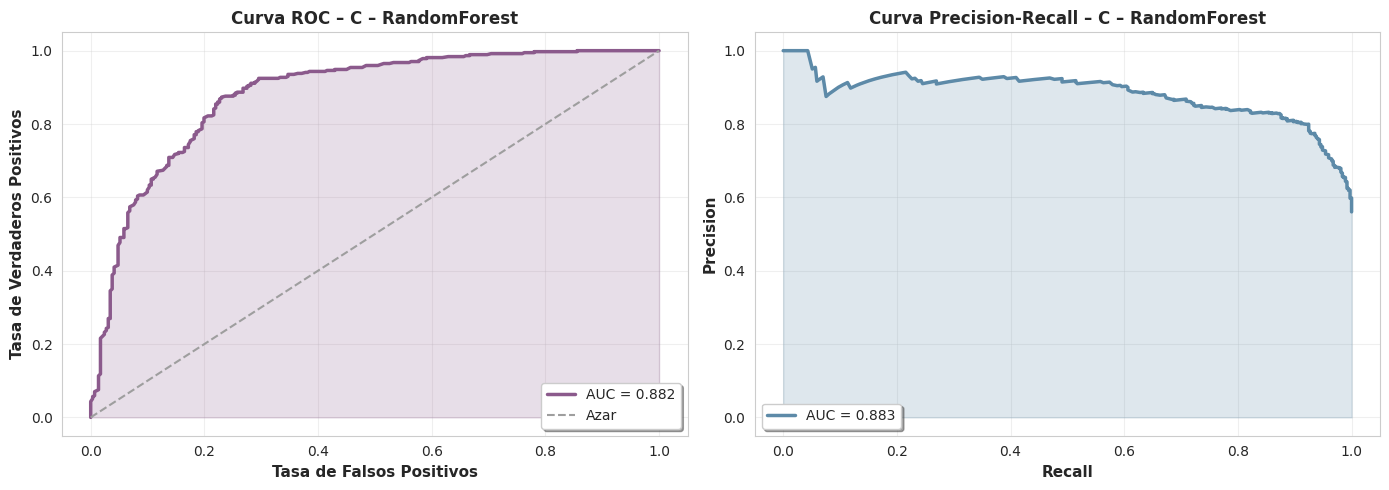

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc, f1_score
from sklearn.model_selection import train_test_split

# Paleta de colores profesional y apropiada para el contexto
COLORS = {
    'primary': '#8B5A8C',      # Púrpura suave (dignidad, empoderamiento)
    'secondary': '#5D8AA8',    # Azul acero (confianza, claridad)
    'accent': '#CD7F32',       # Bronce (calidez, inclusión)
    'negative': '#C77B7B',     # Rojo suave (no agresivo)
    'positive': '#7BA175',     # Verde salvia (esperanza, crecimiento)
    'neutral': '#9E9E9E',      # Gris medio
    'background': '#F5F5F5'    # Gris muy claro
}

# Configurar estilo general
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

def plot_confmat(y_true, y_pred, title="Matriz de Confusión"):
    """Matriz de confusión con colores suaves y profesionales"""
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(y_true.unique())

    fig, ax = plt.subplots(figsize=(8, 6))

    # Usar colores púrpura-blanco para mejor legibilidad
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Frecuencia'},
                linewidths=0.5, linecolor='white',
                ax=ax)

    ax.set_xlabel('Predicción', fontsize=11, fontweight='bold')
    ax.set_ylabel('Valor Real', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.show()

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_pred))

def plot_roc_pr(model, X_test, y_test, task_name="Modelo"):
    """Curvas ROC y Precision-Recall con colores distintivos"""
    # Convertir etiquetas a numéricas si son categóricas
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)

    # Obtener probabilidades
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        print("El modelo no soporta probabilidades.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test_encoded, y_proba)
    roc_auc = auc(fpr, tpr)

    ax1.plot(fpr, tpr, color=COLORS['primary'], linewidth=2.5,
             label=f'AUC = {roc_auc:.3f}')
    ax1.plot([0, 1], [0, 1], color=COLORS['neutral'],
             linestyle='--', linewidth=1.5, label='Azar')
    ax1.fill_between(fpr, tpr, alpha=0.2, color=COLORS['primary'])

    ax1.set_xlabel('Tasa de Falsos Positivos', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Tasa de Verdaderos Positivos', fontsize=11, fontweight='bold')
    ax1.set_title(f'Curva ROC – {task_name}', fontsize=12, fontweight='bold')
    ax1.legend(loc='lower right', frameon=True, shadow=True)
    ax1.grid(True, alpha=0.3)

    # Curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test_encoded, y_proba)
    pr_auc = auc(recall, precision)

    ax2.plot(recall, precision, color=COLORS['secondary'],
             linewidth=2.5, label=f'AUC = {pr_auc:.3f}')
    ax2.fill_between(recall, precision, alpha=0.2, color=COLORS['secondary'])

    ax2.set_xlabel('Recall', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Precision', fontsize=11, fontweight='bold')
    ax2.set_title(f'Curva Precision-Recall – {task_name}',
                  fontsize=12, fontweight='bold')
    ax2.legend(loc='lower left', frameon=True, shadow=True)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def bar_f1_per_class(y_true, y_pred, title="F1-Score por Clase"):
    """Gráfico de barras con colores diferenciados por clase"""
    labels = sorted(y_true.unique())
    f1_scores = []

    for label in labels:
        y_true_bin = (y_true == label).astype(int)
        y_pred_bin = (y_pred == label).astype(int)
        f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
        f1_scores.append(f1)

    # Paleta de colores variada para las categorías
    colors_cat = [COLORS['primary'], COLORS['secondary'],
                  COLORS['accent'], COLORS['positive'], COLORS['negative']]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(range(len(labels)), f1_scores,
                   color=colors_cat[:len(labels)],
                   edgecolor='white', linewidth=1.5, alpha=0.85)

    # Añadir valores sobre las barras
    for i, (bar, score) in enumerate(zip(bars, f1_scores)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.show()

# ===== Uso con tus tareas =====

# ===== Tarea A: Misogynous (0/1) =====
X = df[['text_clean'] + FEATURE_COLS_NUM].copy()
y = df['misogynous'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

bestA_name, bestA_f1, bestA_model = bestA
print(f"Usando mejor modelo A: {bestA_name}  F1={bestA_f1:.4f}")
y_pred_A = bestA_model.predict(X_test)
plot_confmat(y_test, y_pred_A, title=f"A – {bestA_name}")
plot_roc_pr(bestA_model, X_test, y_test, task_name=f"A – {bestA_name}")

# ===== Tarea B: Tipo de misoginia =====
X = df[['text_clean'] + FEATURE_COLS_NUM].copy()
y = df['misogyny_category'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

bestB_name, bestB_f1, bestB_model = bestB
print(f"\nUsando mejor modelo B: {bestB_name}  F1={bestB_f1:.4f}")
y_pred_B = bestB_model.predict(X_test)
plot_confmat(y_test, y_pred_B, title=f"B – {bestB_name}")
bar_f1_per_class(y_test, y_pred_B, title=f"B – {bestB_name} (F1 por clase)")

# ===== Tarea C: Target (active/passive) =====
X = df[['text_clean'] + FEATURE_COLS_NUM].copy()
y = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

bestC_name, bestC_f1, bestC_model = bestC
print(f"\nUsando mejor modelo C: {bestC_name}  F1={bestC_f1:.4f}")
y_pred_C = bestC_model.predict(X_test)
plot_confmat(y_test, y_pred_C, title=f"C – {bestC_name}")
plot_roc_pr(bestC_model, X_test, y_test, task_name=f"C – {bestC_name}")

### Función de prueba interactiva de textos nuevos

En esta sección se implementa una función interactiva que permite ingresar cualquier oración, insulto o comentario y evaluarlo con los modelos entrenados. Para cada texto introducido, la función devuelve:

- **Tarea A**: si el mensaje es misógino o no.
- **Tarea B**: el tipo específico de misoginia detectado.
- **Tarea C**: si el objetivo del ataque es una persona concreta (`active`) o un grupo general (`passive`).

Esta herramienta funciona como un mecanismo de validación cualitativa, ya que permite observar de manera directa cómo se comportan los modelos frente a ejemplos reales o diseñados por el usuario, ilustrando sus aciertos, límites y posibles sesgos.


In [15]:
# ===== CELDA 12: Probar el modelo con textos nuevos =====

def make_example_df(text: str) -> pd.DataFrame:
    """
    Construye un DataFrame con el mismo formato de X
    usando las funciones de limpieza y meta-features ya definidas.
    """
    tmp = pd.DataFrame({'text': [text]})
    meta = add_meta_features(tmp['text'])
    for col in meta.columns:
        tmp[col] = meta[col].astype(float)
    tmp['text_clean'] = tmp['text'].apply(clean_text)

    # Misma estructura que X en el entrenamiento
    X_ex = tmp[['text_clean'] + FEATURE_COLS_NUM].copy()
    return X_ex

def probar_texto(texto: str):
    """
    Imprime las predicciones de los mejores modelos A, B y C
    para un texto dado.
    """
    X_ex = make_example_df(texto)

    print("====================================")
    print("TEXTO:", texto)
    print("====================================")

    # A – misogynous (0/1)
    if 'bestA_model' in globals() and bestA_model is not None:
        pred_A = bestA_model.predict(X_ex)[0]
        print(f"A) ¿Misógino? -> {pred_A}")

    # B – tipo de misoginia
    if 'bestB_model' in globals() and bestB_model is not None:
        pred_B = bestB_model.predict(X_ex)[0]
        print(f"B) Tipo de misoginia -> {pred_B}")

    # C – target (active/passive)
    if 'bestC_model' in globals() and bestC_model is not None:
        pred_C = bestC_model.predict(X_ex)[0]
        print(f"C) Tipo de objetivo -> {pred_C}")


In [16]:
# Ejemplos claramente misóginos
probar_texto("Cállate perra, no sirves para nada.")
probar_texto("Todas las mujeres son unas zorras interesadas.")
probar_texto("Te voy a pegar y así aprendes a obedecer, perra.")
probar_texto("callate zorra malnacida ")



# Ejemplo con insulto pero NO necesariamente misógino
probar_texto("Eres un imbécil, ya cállate.")

# Ejemplo neutro/positivo
probar_texto("Hoy tuve una conversación muy interesante sobre igualdad de género.")

TEXTO: Cállate perra, no sirves para nada.
A) ¿Misógino? -> 1
B) Tipo de misoginia -> dominance
C) Tipo de objetivo -> active
TEXTO: Todas las mujeres son unas zorras interesadas.
A) ¿Misógino? -> 1
B) Tipo de misoginia -> stereotype
C) Tipo de objetivo -> active
TEXTO: Te voy a pegar y así aprendes a obedecer, perra.
A) ¿Misógino? -> 1
B) Tipo de misoginia -> discredit
C) Tipo de objetivo -> active
TEXTO: callate zorra malnacida 
A) ¿Misógino? -> 1
B) Tipo de misoginia -> dominance
C) Tipo de objetivo -> active
TEXTO: Eres un imbécil, ya cállate.
A) ¿Misógino? -> 1
B) Tipo de misoginia -> dominance
C) Tipo de objetivo -> active
TEXTO: Hoy tuve una conversación muy interesante sobre igualdad de género.
A) ¿Misógino? -> 0
B) Tipo de misoginia -> none
C) Tipo de objetivo -> passive


### Figura X. Importancia global de palabras según valores SHAP

En la Figura X se muestran las palabras que más influyen en la detección de misoginia, medidas con valores SHAP. El eje horizontal indica el **impacto medio** que tiene cada término sobre la decisión del modelo: cuanto más larga es la barra, mayor es la capacidad de esa palabra para cambiar la predicción. En el eje vertical aparecen las palabras que el modelo encuentra en los comentarios.

Se observa que insultos directos como **“perra”**, **“la puta”**, **“hijo de”** o **“puta madre”** concentran los valores más altos. Esto significa que, cuando estas expresiones aparecen en un texto, casi siempre aumentan la probabilidad de que el modelo lo clasifique como misógino. En cambio, otras expresiones con barras más cortas tienen un efecto mucho menor y aportan poca información para distinguir entre comentarios misóginos y no misóginos.

---

### Figura Y. Efecto de cada palabra caso por caso (beeswarm SHAP)

La Figura Y muestra cómo esas mismas palabras afectan la predicción **comentario por comentario**. Cada punto de la gráfica representa un mensaje del conjunto de datos, y su posición en el eje horizontal indica si la presencia de esa palabra empuja la predicción hacia la clase misógina (puntos desplazados hacia la derecha) o hacia la clase no misógina (puntos hacia la izquierda).

Para términos altamente ofensivos como **“perra”**, **“la puta”** o **“puta madre”**, la mayoría de los puntos se concentran en valores positivos, lo que refleja que, en la gran mayoría de los casos, su aparición mueve al modelo hacia la categoría misógina. En cambio, expresiones más neutras o ambiguas, como **“una mujer”** o **“eres”**, muestran puntos más cercanos a cero o con un efecto menos consistente. Esto sugiere que su interpretación depende en buena medida del contexto en el que aparecen dentro de cada comentario.


Número total de features: 33135

=== Gráfica 1: Importancia global (todas las features) ===


/tmp/ipython-input-2428936512.py:71: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


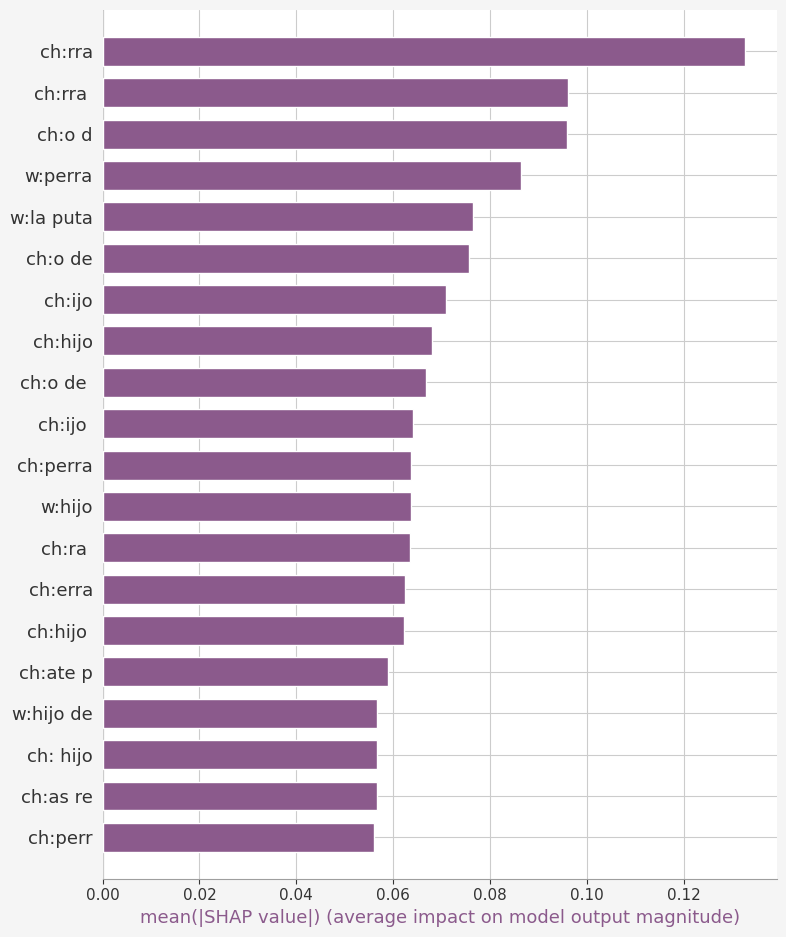


=== Gráfica 2: Importancia solo de palabras (bar) ===


/tmp/ipython-input-2428936512.py:91: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


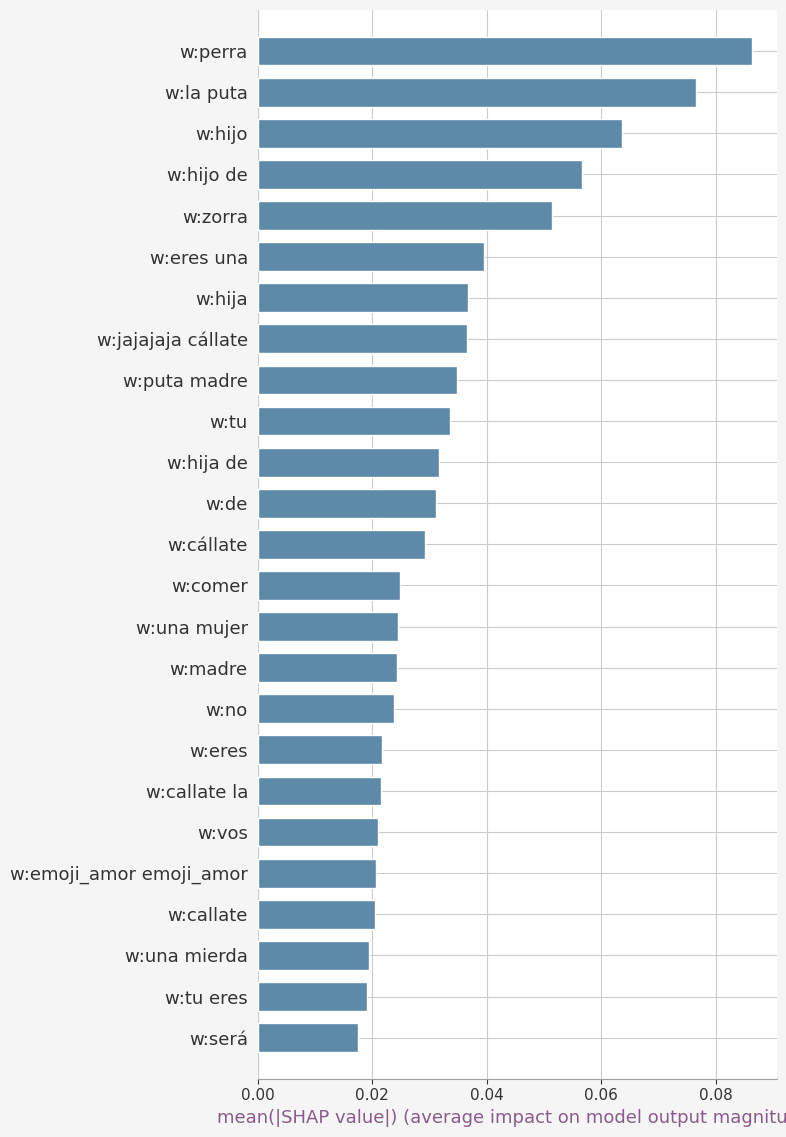


=== Gráfica 3: Distribución SHAP de palabras ===


/tmp/ipython-input-2428936512.py:106: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


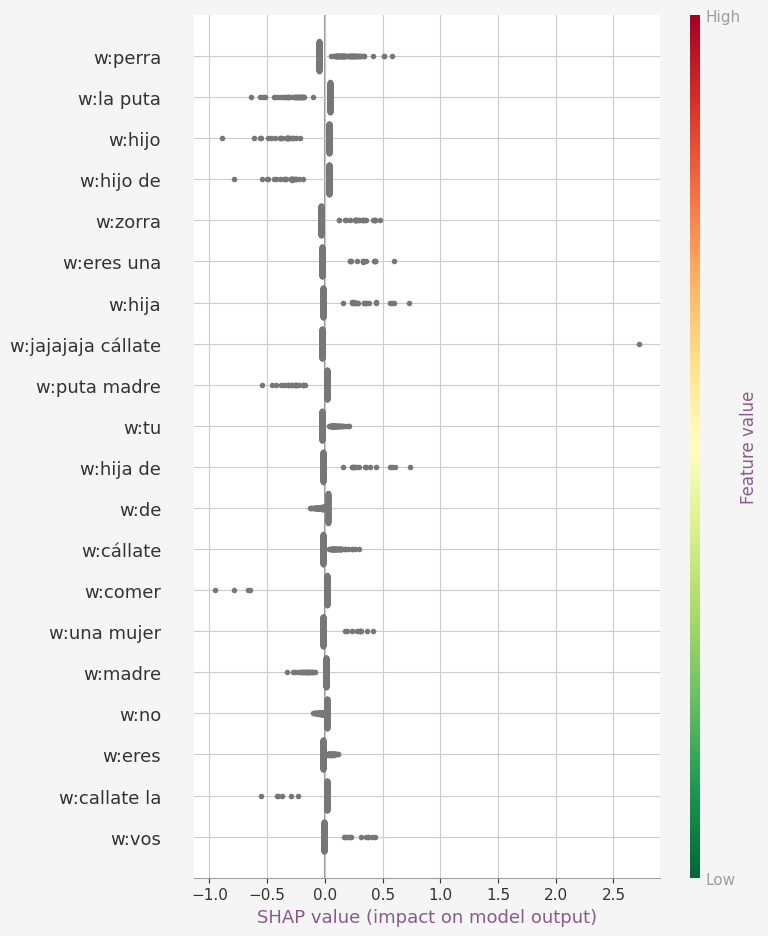


=== Gráfica 4: Top 20 features por magnitud SHAP ===


/tmp/ipython-input-2428936512.py:123: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


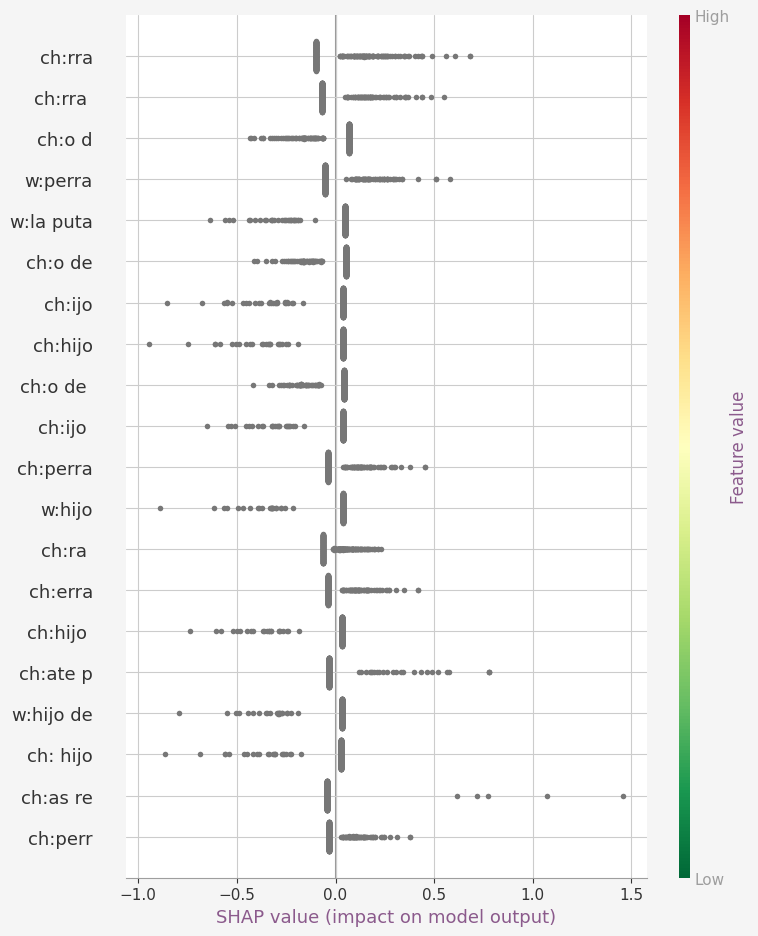


✓ Análisis SHAP completado


In [22]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Paleta de colores profesional para conferencia
COLORS = {
    'primary': '#8B5A8C',      # Púrpura suave (dignidad, empoderamiento)
    'secondary': '#5D8AA8',    # Azul acero (confianza, claridad)
    'accent': '#CD7F32',       # Bronce (calidez, inclusión)
    'negative': '#C77B7B',     # Rojo suave (no agresivo)
    'positive': '#7BA175',     # Verde salvia (esperanza, crecimiento)
    'neutral': '#9E9E9E',      # Gris medio
    'background': '#F5F5F5'    # Gris muy claro
}

# Configurar estilo de matplotlib para la presentación
plt.rcParams['figure.facecolor'] = COLORS['background']
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = COLORS['neutral']
plt.rcParams['axes.labelcolor'] = COLORS['primary']
plt.rcParams['xtick.color'] = COLORS['neutral']
plt.rcParams['ytick.color'] = COLORS['neutral']
plt.rcParams['text.color'] = COLORS['primary']
plt.rcParams['font.size'] = 11

# ===== SHAP para Tarea A (LASSO_LogReg, text_clean + TF-IDF) =====

# 1. Tomamos el pipeline entrenado de LASSO para Tarea A
lasso_pipe_A = res_A['LASSO_LogReg']['model']

prep = lasso_pipe_A.named_steps['prep']      # ColumnTransformer
scaler = lasso_pipe_A.named_steps['scale']   # StandardScaler
clf    = lasso_pipe_A.named_steps['clf']     # LogisticRegression L1

# 2. Construimos la matriz de entrenamiento ya transformada (TF-IDF + numéricas)
X_train_pre   = prep.transform(X_train)          # TF-IDF (word + char) + num
X_train_scaled = scaler.transform(X_train_pre)   # Después del StandardScaler

# 3. Recuperar los nombres de las features de text_clean
word_vect = prep.named_transformers_['word_tfidf']
char_vect = prep.named_transformers_['char_tfidf']

feature_names_word = np.array([f"w:{w}" for w in word_vect.get_feature_names_out()])
feature_names_char = np.array([f"ch:{c}" for c in char_vect.get_feature_names_out()])
feature_names_num  = np.array(FEATURE_COLS_NUM)

feature_names = np.concatenate([
    feature_names_word,
    feature_names_char,
    feature_names_num
])

print(f"Número total de features: {len(feature_names)}")

# 4. Creamos el explainer SHAP para el modelo lineal
#    Usamos una muestra de fondo (background) para no explotar la RAM
background_size = min(300, X_train_scaled.shape[0])
X_background = X_train_scaled[:background_size]

explainer = shap.LinearExplainer(clf, X_background)

# 5. Calculamos los valores SHAP sobre una muestra de ejemplos
n_explain = min(300, X_train_scaled.shape[0])
X_explain = X_train_scaled[:n_explain]

shap_values = explainer(X_explain)

# 6. Gráfica global de importancia (summary plot tipo bar)
print("\n=== Gráfica 1: Importancia global (todas las features) ===")
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values.values,
    features=X_explain,
    feature_names=feature_names,
    max_display=20,
    plot_type="bar",
    color=COLORS['primary'],
    show=False
)
plt.tight_layout()
plt.show()

# 7. SHAP solo para features de palabras (bar plot)
print("\n=== Gráfica 2: Importancia solo de palabras (bar) ===")
mask_words = np.array([name.startswith("w:") for name in feature_names])
X_explain_words = X_explain[:, mask_words]
shap_values_words = shap_values.values[:, mask_words]
feature_names_words = feature_names[mask_words]

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_words,
    features=X_explain_words,
    feature_names=feature_names_words,
    max_display=25,
    plot_type="bar",
    color=COLORS['secondary'],
    show=False
)
plt.tight_layout()
plt.show()

# 8. SHAP solo para palabras (summary plot con distribución)
print("\n=== Gráfica 3: Distribución SHAP de palabras ===")
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values.values[:, mask_words],
    features=X_explain[:, mask_words],
    feature_names=feature_names[mask_words],
    max_display=20,
    cmap=plt.cm.RdYlGn_r,
    show=False
)
plt.tight_layout()
plt.show()

# 9. Top 20 features por magnitud media de SHAP
print("\n=== Gráfica 4: Top 20 features por magnitud SHAP ===")
mean_abs = np.abs(shap_values.values).mean(axis=0)
idx_top = np.argsort(mean_abs)[-20:]

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values.values[:, idx_top],
    features=X_explain[:, idx_top],
    feature_names=feature_names[idx_top],
    cmap=plt.cm.RdYlGn_r,
    show=False
)
plt.tight_layout()
plt.show()

print("\n✓ Análisis SHAP completado")

### Carga de nuevos datos desde archivos Excel o CSV

En esta sección se habilita la lectura de nuevos comentarios almacenados en una “base de datos” en formato de archivo, ya sea **Excel (`.xlsx`)** o **CSV (`.csv`)**.


In [24]:
model_A = joblib.load("best_A_misogynous.joblib")
model_B = joblib.load("best_B_category.joblib")
model_C = joblib.load("best_C_target.joblib")

print("Modelos cargados:")
print(type(model_A), type(model_B), type(model_C))



Modelos cargados:
<class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'>


In [25]:
print("Sube el archivo con los tweets NUEVOS (CSV o Excel)")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print("Archivo recibido:", file_name)

if file_name.lower().endswith(".csv"):
    df = pd.read_csv(file_name)
elif file_name.lower().endswith((".xlsx", ".xls")):
    df = pd.read_excel(file_name)
else:
    raise ValueError("Formato no soportado. Usa CSV o Excel.")

df.columns = df.columns.str.lower().str.strip()

# Asegurar columna de texto
if "text" not in df.columns:
    for c in ["tweet", "mensaje", "texto"]:
        if c in df.columns:
            df = df.rename(columns={c: "text"})
            break

if "text" not in df.columns:
    raise ValueError("No encuentro columna de texto ('text', 'tweet', 'mensaje' o 'texto').")

df["text"] = df["text"].fillna("").astype(str)
df.head()


Sube el archivo con los tweets NUEVOS (CSV o Excel)


Saving Prueba.xlsx to Prueba.xlsx
Archivo recibido: Prueba.xlsx


,id,text
0,3400,Luego en marzo que Adán saque la bufanda rosa ...
1,3401,@reginabisex Unmnmnn imagino q tú eres así ó m...
2,3402,"@laSextaTV Tú eres un HDLGP, vosotros sí que s..."
3,3403,@Manaka_msyra @BrianD_Campbell callate zorra m...
4,3404,@Eli_la_faldas Yo tengo una con forma de polla


In [26]:
import unicodedata
import string

def clean_text_basic(s: str) -> str:
    s = s.lower()
    # quitar acentos
    s = ''.join(
        c for c in unicodedata.normalize('NFKD', s)
        if not unicodedata.combining(c)
    )
    # quitar saltos
    s = s.replace("\n", " ").replace("\r", " ")
    return s

# 1) text_clean (lo que tu ColumnTransformer espera)
df["text_clean"] = df["text"].apply(clean_text_basic)

# 2) n_url
df["n_url"] = df["text"].str.count(r"http[s]?://") + df["text"].str.count(r"www\.")

# 3) n_user (@usuario)
df["n_user"] = df["text"].str.count(r"@\w+")

# 4) n_hash (#hashtag)
df["n_hash"] = df["text"].str.count(r"#\w+")

# 5) n_emoji (aprox)
emoji_pattern = re.compile(
    "["
    u"\U0001F300-\U0001F5FF"
    u"\U0001F600-\U0001F64F"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    "]+",
    flags=re.UNICODE
)

def count_emoji(s):
    return len(emoji_pattern.findall(str(s)))

df["n_emoji"] = df["text"].apply(count_emoji)

# 6) n_char
df["n_char"] = df["text"].str.len()

# 7) upper_ratio
upper_count = df["text"].str.count(r"[A-ZÁÉÍÓÚÑ]")
df["upper_ratio"] = upper_count / df["n_char"].replace(0, 1)

feature_cols = ["text_clean", "n_url", "n_user", "n_hash", "n_emoji", "n_char", "upper_ratio"]
X_new = df[feature_cols]

X_new.head()


,text_clean,n_url,n_user,n_hash,n_emoji,n_char,upper_ratio
0,luego en marzo que adan saque la bufanda rosa ...,1,0,0,0,182,0.065934
1,@reginabisex unmnmnn imagino q tu eres asi o m...,0,1,0,0,53,0.018868
2,"@lasextatv tu eres un hdlgp, vosotros si que s...",0,1,0,0,58,0.155172
3,@manaka_msyra @briand_campbell callate zorra m...,0,2,0,0,113,0.035398
4,@eli_la_faldas yo tengo una con forma de polla,0,1,0,0,46,0.043478


In [27]:
df["pred_A_misogynous"] = model_A.predict(X_new)
df["pred_B_category"]   = model_B.predict(X_new)
df["pred_C_target"]     = model_C.predict(X_new)

df[["text", "pred_A_misogynous", "pred_B_category", "pred_C_target"]].head()


,text,pred_A_misogynous,pred_B_category,pred_C_target
0,Luego en marzo que Adán saque la bufanda rosa ...,1,discredit,active
1,@reginabisex Unmnmnn imagino q tú eres así ó m...,1,discredit,active
2,"@laSextaTV Tú eres un HDLGP, vosotros sí que s...",1,discredit,active
3,@Manaka_msyra @BrianD_Campbell callate zorra m...,1,discredit,active
4,@Eli_la_faldas Yo tengo una con forma de polla,0,none,passive
